Marcin Wardyński  
wtorek, 9:45

## Laboratorium 7 - RBM, DBN, Autoenkoder

In [130]:
from enum import Enum

seed = 42

class Dataset_Select(Enum):
    MNIST = "mnist"
    F_MNIST = "fashion_mnist"
    K_MNIST = "kmnist"
    KUZ_49 = "Kuzushiji-49"

In [131]:
from datasets import load_dataset
import matplotlib.pyplot as plt
import numpy as np
import tensorflow_datasets as tfds
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

def fetch_from_hg(dataset_name):
    dataset = load_dataset(dataset_name)

    X_train = dataset['train']['image']
    X_test = dataset['test']['image']
    y_train = dataset['train']['label']
    y_test = dataset['test']['label']

    X_train = np.array([np.array(image) for image in X_train])
    X_test = np.array([np.array(image) for image in X_test])

    return X_train, X_test, y_train, y_test

def convert_tsfl_dataset_to_nparray(dataset):
    images = []
    labels = []
    for image, label in tfds.as_numpy(dataset):
        images.append(image)
        labels.append(label)
    
    return np.array(images), labels

def fetch_from_tsfl(dataset_name):
    dataset = tfds.load(dataset_name, split=["train", "test"], as_supervised=True)

    train_dataset, test_dataset = dataset

    X_train, y_train = convert_tsfl_dataset_to_nparray(train_dataset)
    X_test, y_test = convert_tsfl_dataset_to_nparray(test_dataset)

    return X_train, X_test, y_train, y_test

def fetch_from_openml(dataset_name):
    dataset = fetch_openml(name=dataset_name, version=1)

    X = dataset.data.to_numpy()
    X = X.reshape(X.shape[0], 28, 28)
    y = dataset.target.to_numpy()

    return train_test_split(X, y, test_size=1/(1+6), random_state=seed)

def select_fetch_fucntion(dataset_name):
    if dataset_name == Dataset_Select.KUZ_49.value:
        fetch_fun = fetch_from_openml
    elif dataset_name == Dataset_Select.K_MNIST.value:
        fetch_fun = fetch_from_tsfl
    else:
        fetch_fun = fetch_from_hg
    return fetch_fun

def print_samples(images, n):
    plt.figure(figsize=(n, 2))
    for i in range(n):
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(images[i])
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

def binarize(X_train, X_test):
    X_train = X_train.reshape((X_train.shape[0], 28, 28)) / 255.
    X_train = np.where(X_train > .5, 1.0, 0.0).astype(np.uint8)

    X_test = X_test.reshape((X_test.shape[0], 28, 28)) / 255.
    X_test = np.where(X_test > .5, 1.0, 0.0).astype(np.uint8)

    return X_train, X_test

def flatten_image(X_train, X_test):
    X_train = X_train.reshape((X_train.shape[0], 784))
    X_test = X_test.reshape((X_test.shape[0], 784))
    
    return X_train, X_test



def get_dataset(dataset_name, print_sample_number):
    fetch_fun = select_fetch_fucntion(dataset_name)

    X_train, X_test, y_train, y_test = fetch_fun(dataset_name)

    X_train, X_test = binarize(X_train, X_test)

    if print_sample_number > 0:
        print_samples(X_train, print_sample_number)

    X_train, X_test = flatten_image(X_train, X_test)

    return X_train, X_test, y_train, y_test
   


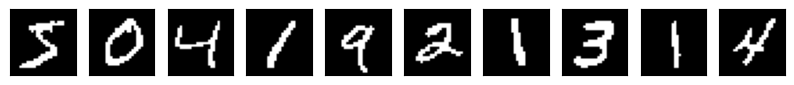

In [104]:
get_dataset("mnist", 10)

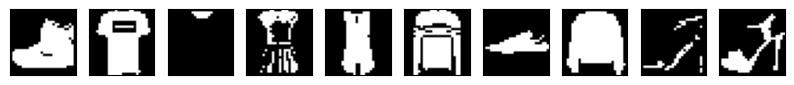

In [105]:
get_dataset("fashion_mnist", 10)

2024-12-29 19:21:21.013606: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


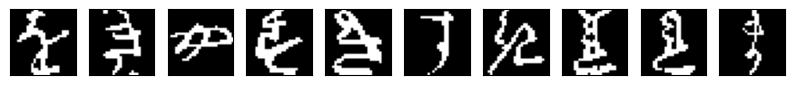

In [106]:
get_dataset("kmnist", 10)

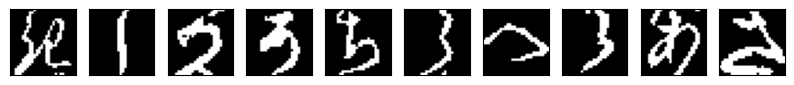

In [107]:
get_dataset("Kuzushiji-49", 10)

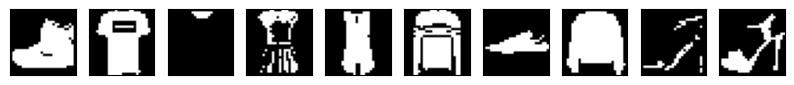

In [133]:
X_train, X_test, y_train, y_test = get_dataset(Dataset_Select.F_MNIST.value, 10)

In [125]:
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import BernoulliRBM
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score

logistic = linear_model.LogisticRegression(solver="newton-cg", tol=1)
rbm = BernoulliRBM(random_state=0, verbose=True)

rbm_features_classifier = Pipeline(steps=[("rbm", rbm), ("logistic", logistic)])

In [126]:
pipeline = Pipeline([
    ('rbm', BernoulliRBM(n_components=256, learning_rate=0.01, n_iter=10, random_state=42)),
    ('logistic', LogisticRegression(max_iter=1000, solver='lbfgs'))
])

# Train the pipeline
pipeline.fit(X_train, y_train)

# Make predictions on the test set
y_pred = pipeline.predict(X_test)

# Evaluate the model's accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')

Accuracy: 95.42%


In [128]:
logistic = LogisticRegression(max_iter=1000, solver='lbfgs')

logistic.fit(X_train, y_train)

y_pred = logistic.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')

Accuracy: 91.68%


In [123]:
from sklearn.base import clone


rbm.learning_rate = 0.06
rbm.n_iter = 10


rbm.n_components = 500
logistic.C = 6000

# Training RBM-Logistic Pipeline
rbm_features_classifier.fit(X_train, y_train)

raw_pixel_classifier = clone(logistic)
raw_pixel_classifier.C = 0.5
raw_pixel_classifier.fit(X_train, y_train)

[BernoulliRBM] Iteration 1, pseudo-likelihood = -88.39, time = 18.29s
[BernoulliRBM] Iteration 2, pseudo-likelihood = -87.01, time = 20.17s
[BernoulliRBM] Iteration 3, pseudo-likelihood = -88.67, time = 19.92s
[BernoulliRBM] Iteration 4, pseudo-likelihood = -86.49, time = 19.74s
[BernoulliRBM] Iteration 5, pseudo-likelihood = -82.35, time = 20.05s
[BernoulliRBM] Iteration 6, pseudo-likelihood = -85.80, time = 18.76s
[BernoulliRBM] Iteration 7, pseudo-likelihood = -85.29, time = 19.29s
[BernoulliRBM] Iteration 8, pseudo-likelihood = -90.93, time = 19.34s
[BernoulliRBM] Iteration 9, pseudo-likelihood = -90.63, time = 20.06s
[BernoulliRBM] Iteration 10, pseudo-likelihood = -81.47, time = 20.92s


LogisticRegression(C=0.5, solver='newton-cg', tol=1)

In [124]:
from sklearn import metrics

y_pred = rbm_features_classifier.predict(X_test)
print(
    "Logistic regression using RBM features:\n%s\n"
    % (metrics.classification_report(y_test, y_pred))
)

Logistic regression using RBM features:
              precision    recall  f1-score   support

           0       0.10      1.00      0.18       980
           1       0.00      0.00      0.00      1135
           2       0.00      0.00      0.00      1032
           3       0.00      0.00      0.00      1010
           4       0.00      0.00      0.00       982
           5       0.00      0.00      0.00       892
           6       0.00      0.00      0.00       958
           7       0.00      0.00      0.00      1028
           8       0.00      0.00      0.00       974
           9       0.00      0.00      0.00      1009

    accuracy                           0.10     10000
   macro avg       0.01      0.10      0.02     10000
weighted avg       0.01      0.10      0.02     10000




/Users/mwardynski/Documents/ds/_semestr_9/uczenie_maszynowe/labs/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/mwardynski/Documents/ds/_semestr_9/uczenie_maszynowe/labs/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/mwardynski/Documents/ds/_semestr_9/uczenie_maszynowe/labs/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. U